# Universidad ICESI

*Milton Sarria*

---
## Introducción a las Máquinas de Soporte Vectorial (SVM)

Las **Máquinas de Soporte Vectorial (SVM)** son un conjunto poderoso de técnicas supervisadas de aprendizaje utilizadas para clasificación y regresión. El enfoque central de las SVM es encontrar un **hiperplano óptimo** que separe distintas clases en un espacio de características, maximizando el **margen** que existe entre ellas. En esencia, SVM busca el hiperplano que no solo separa las clases, sino que lo hace con la mayor distancia posible a los puntos de entrenamiento más cercanos de cada clase (conocidos como **vectores de soporte**).

### 1. SVM con **Kernel Lineal**
Comenzamos con el caso más simple: el **kernel lineal**. El objetivo es encontrar una **frontera de decisión lineal** en el espacio de características original.

#### Formulación
Dado un conjunto de datos de entrenamiento:
$$
\{(\mathbf{x}_i, y_i)\}_{i=1}^n, \quad \mathbf{x}_i \in \mathbb{R}^p, \quad y_i \in \{-1, 1\}
$$
El SVM lineal busca un hiperplano definido por:
$$
f(\mathbf{x}) = \mathbf{w}^T \mathbf{x} + b = 0
$$
donde:
- $ \mathbf{w}$ es el vector normal al hiperplano.
- $ b $ es el sesgo (bias).

El **margen** es $ \frac{2}{\|\mathbf{w}\|} $, por lo que el problema de optimización busca minimizar $ \|\mathbf{w}\|^2 $ bajo las restricciones:
$$
y_i (\mathbf{w}^T \mathbf{x}_i + b) \geq 1, \quad \forall i
$$

#### Hiperparámetro: **\( C \)**
En problemas donde los datos no son perfectamente separables, se permite cierta **violación del margen** mediante variables de holgura $ \xi_i $, controladas por el hiperparámetro $C $:
$$
\min_{\mathbf{w}, b} \frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^n \xi_i
$$
- **$ C $** controla el **balance entre un margen amplio y los errores de clasificación**:
  - Un **$ C $** grande penaliza mucho los errores ⇒ modelo con menor margen pero menos errores en entrenamiento (riesgo de sobreajuste).
  - Un **$ C $** pequeño permite más errores ⇒ margen más amplio, modelo más simple y con mejor generalización.

---



In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_classification, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



# CASO 1: Dataset linealmente separable

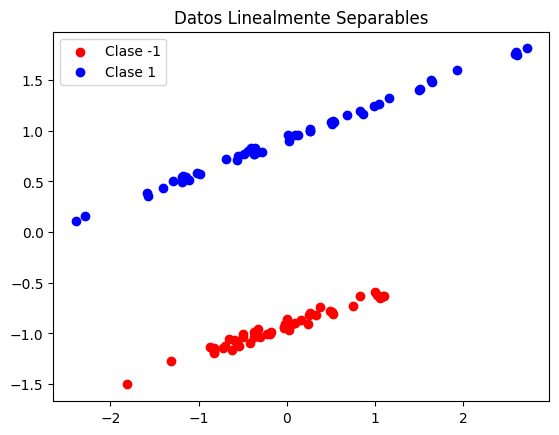

In [8]:
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=42
)

# Escalado (muy recomendado para SVM)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Visualización
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Clase -1')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Clase 1')
plt.title('Datos Linealmente Separables')
plt.legend()
plt.show()

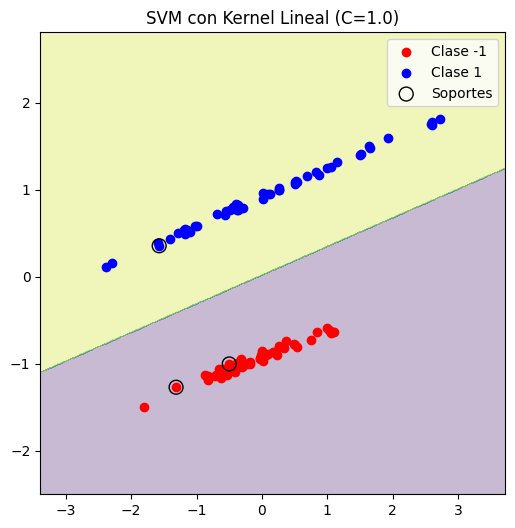

In [9]:
# Entrenamiento SVM con kernel lineal
svc_linear = svm.SVC(kernel='linear', C=1.0)
svc_linear.fit(X, y)

# Función para graficar la frontera de decisión
def plot_decision_boundary(clf, X, y, title):
    plt.figure(figsize=(6, 6))
    
    # Malla
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    
    # Predicciones en la malla
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Contorno y datos
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Clase -1')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Clase 1')
    
    # Vectores de soporte
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], 
                s=100, facecolors='none', edgecolors='k', label='Soportes')
    
    plt.title(title)
    plt.legend()
    plt.show()

plot_decision_boundary(svc_linear, X, y, 'SVM con Kernel Lineal (C=1.0)')


# CASO 2: dataset con algunos puntos muy cerca de la frontera

In [12]:
np.random.seed(5)

X = np.random.randn(20,2)
y = np.repeat([1,-1],10)

X[y==1]=X[y==1]+2

df_0 = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
df_0.columns= ['x1','x2','y']
df_0.head()

,x1,x2,y
0,2.441227,1.669130,1
1,4.430771,1.747908,1
2,2.109610,3.582481,1
3,1.090768,1.408363,1
4,2.187603,1.670130,1


<Axes: xlabel='x1', ylabel='x2'>

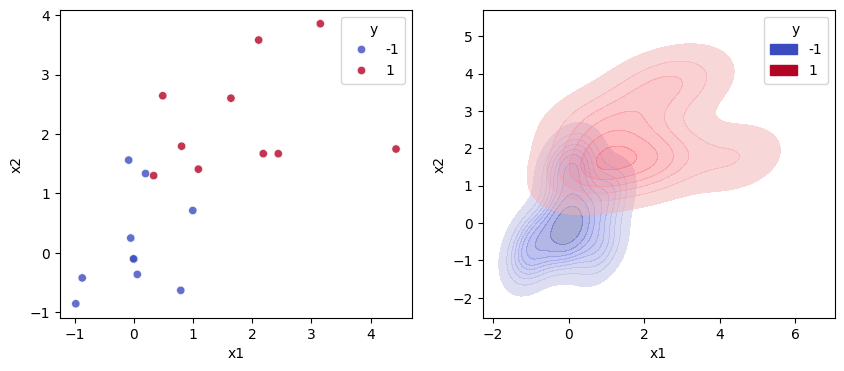

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
sns.scatterplot(
    data=df_0,
    x="x1",
    y="x2",
    hue="y",  # Diferencia puntos según las etiquetas
    palette="coolwarm",  # Paleta de colores para -1 y 1
    alpha=0.8  # Transparencia
)

plt.subplot(1,2,2)
sns.kdeplot(
    data=df_0,
    x="x1",
    y="x2",
    hue="y",
    fill=True,  # Para sombrear las áreas de densidad
    alpha=0.5,  # Transparencia
    palette="coolwarm"  # Paleta de colores
)


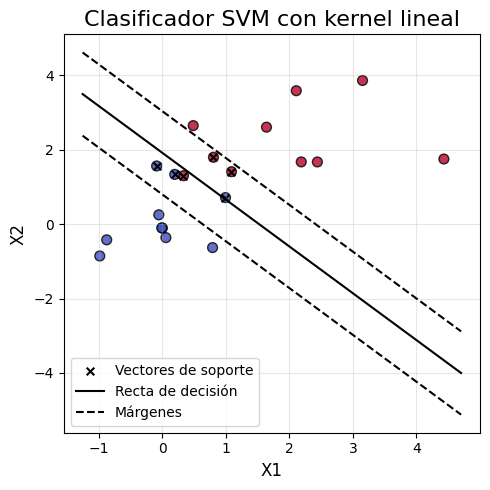

In [18]:

# Separar las características y las etiquetas
X = df_0[['x1', 'x2']].values
y = df_0['y'].values

# Asegurarse de que las etiquetas sean numéricas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # -1 -> 0, 1 -> 1 si fuera necesario

# Entrenar el modelo SVC con kernel lineal, variar C 1 a 100000
svc = SVC(kernel='linear', C=1)
svc.fit(X, y_encoded)

# Obtener los coeficientes de la recta de decisión
w = svc.coef_[0]
b = svc.intercept_[0]

# Crear el gráfico
plt.figure(figsize=(5, 5))

# Graficar los puntos según sus etiquetas
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=50, alpha=0.8, edgecolors='k')

# Marcar los vectores de soporte con 'x'
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], 
            s=30, marker='x',  facecolors='k',label="Vectores de soporte")

# Dibujar la recta de decisión y los márgenes
x_min, x_max = plt.xlim()
x_vals = np.linspace(x_min, x_max, 100)
y_vals_decision = -(w[0] / w[1]) * x_vals - b / w[1]
y_vals_margin1 = y_vals_decision + 1 / w[1]
y_vals_margin2 = y_vals_decision - 1 / w[1]

plt.plot(x_vals, y_vals_decision, 'k-', label="Recta de decisión")
plt.plot(x_vals, y_vals_margin1, 'k--', label="Márgenes")
plt.plot(x_vals, y_vals_margin2, 'k--')

# Configuración del gráfico
plt.title("Clasificador SVM con kernel lineal", fontsize=16)
plt.xlabel("X1", fontsize=12)
plt.ylabel("X2", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {'C': [0.1, 1, 10, 100, 1000]}
# Configurar el GridSearchCV
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',  # Métrica de evaluación
    cv=5,  # Número de particiones para validación cruzada
    verbose=1,  # Mostrar progreso
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Realizar el GridSearch
grid_search.fit(X, y)

# Obtener los resultados
print("Mejor valor de C:", grid_search.best_params_['C'])
print("Mejor precisión promedio:", grid_search.best_score_)

# Reporte detallado para cada configuración
print("\nReporte detallado:")
results = pd.DataFrame(grid_search.cv_results_)
print(results[['param_C', 'mean_test_score', 'std_test_score']])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejor valor de C: 0.1
Mejor precisión promedio: 0.95

Reporte detallado:
   param_C  mean_test_score  std_test_score
0      0.1             0.95        0.100000
1      1.0             0.80        0.187083
2     10.0             0.80        0.187083
3    100.0             0.80        0.187083
4   1000.0             0.80        0.187083


### 2. SVM con **Kernel Polinómico**
Si los datos **no son linealmente separables en el espacio original**, podemos transformarlos a un espacio de características de **mayor dimensión**. En vez de calcular explícitamente esa transformación, usamos una **función kernel** que permite calcular productos internos en el espacio transformado **sin tener que calcular la transformación explícita**.

#### Kernel Polinómico
El **kernel polinómico** se define como:
$$
K(\mathbf{x}_i, \mathbf{x}_j) = (\gamma \mathbf{x}_i^T \mathbf{x}_j + r)^d
$$
- **$\gamma $** es un factor de escala (a veces \( 1 \) si no se especifica).
- **$ r $** es un término independiente que permite flexibilidad en el desplazamiento.
- **$ d $** es el **grado del polinomio**.

#### Efecto de los hiperparámetros:
- **$ d $**: Aumenta la complejidad del modelo. Un grado alto permite que el modelo capture relaciones más complejas, pero con riesgo de **sobreajuste**.
- **$ \gamma $**: Controla la influencia de un solo ejemplo. Si es muy grande, puede hacer que el modelo se ajuste demasiado a los datos de entrenamiento.
- **$r $**: Afecta la flexibilidad del límite de decisión. Ajustarlo adecuadamente puede mejorar el rendimiento, aunque a menudo se fija a valores estándar.

---



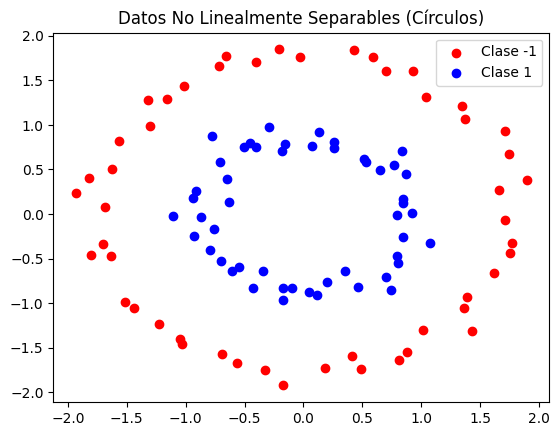

In [30]:
# Datos con patrones no lineales
X_poly, y_poly = make_circles(n_samples=100, factor=0.5, noise=0.05, random_state=42)

# Escalado
X_poly = scaler.fit_transform(X_poly)

# Visualización
plt.scatter(X_poly[y_poly == 0, 0], X_poly[y_poly == 0, 1], color='red', label='Clase -1')
plt.scatter(X_poly[y_poly == 1, 0], X_poly[y_poly == 1, 1], color='blue', label='Clase 1')
plt.title('Datos No Linealmente Separables (Círculos)')
plt.legend()
plt.show()

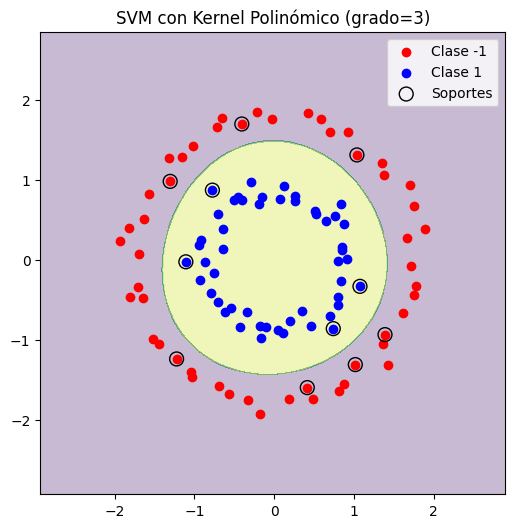

In [31]:
# SVM con kernel polinómico (grado 3)
svc_poly = svm.SVC(kernel='poly', degree=3, C=1.0, coef0=1, gamma='scale')
svc_poly.fit(X_poly, y_poly)

plot_decision_boundary(svc_poly, X_poly, y_poly, 'SVM con Kernel Polinómico (grado=3)')

#### ➡️ Prueba con un **grado mayor** (d=5):

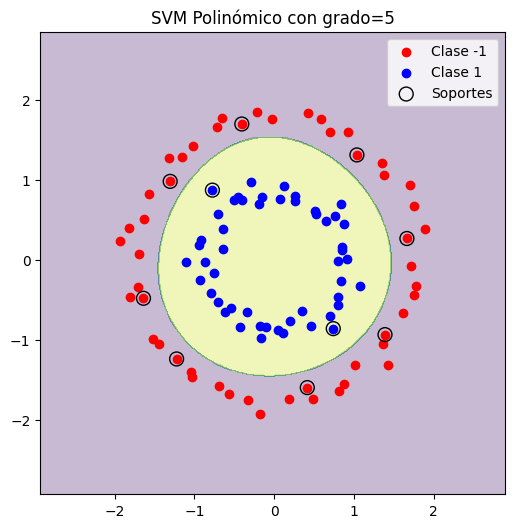

In [32]:
svc_poly_deg5 = svm.SVC(kernel='poly', degree=5, C=1.0, coef0=1, gamma='scale')
svc_poly_deg5.fit(X_poly, y_poly)

plot_decision_boundary(svc_poly_deg5, X_poly, y_poly, 'SVM Polinómico con grado=5')

### 3. SVM con **Kernel Gaussiano (RBF - Radial Basis Function)**
El **kernel gaussiano**, también conocido como **RBF**, es uno de los más populares. Proporciona una manera de crear **fronteras de decisión no lineales** al mapear los datos a un espacio de características de **dimensión infinita**.

#### Kernel RBF
$$
K(\mathbf{x}_i, \mathbf{x}_j) = \exp(-\gamma \|\mathbf{x}_i - \mathbf{x}_j\|^2)
$$
- **$ \gamma $** es el hiperparámetro clave:
  - Un **$ \gamma$** grande implica que cada punto tiene una **influencia muy local**, lo que permite capturar detalles finos pero puede conducir a sobreajuste.
  - Un **$\gamma $** pequeño hace que la influencia sea más **global**, lo que suaviza la frontera de decisión y puede **subajustar**.

#### Combinación de $ C $ y $ \gamma $:
- **$C $** controla el margen y penaliza errores como en el kernel lineal.
- **$ \gamma $** controla la forma de la frontera de decisión.
- La **combinación de ambos** define el **trade-off entre un ajuste muy rígido o muy laxo**.



# CASO 1: datos separables con frontera no lineal

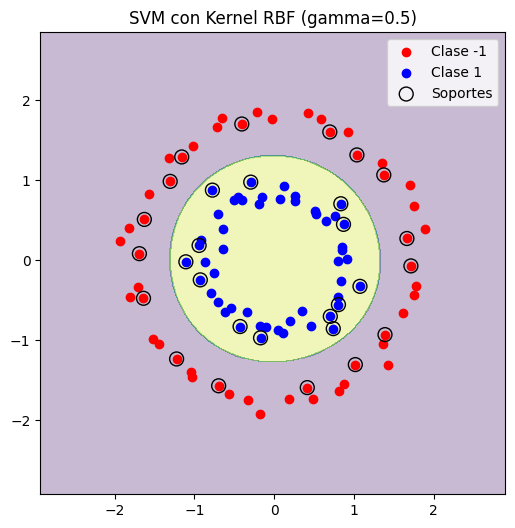

In [33]:

# SVM con kernel RBF (gaussiano)
svc_rbf = svm.SVC(kernel='rbf', C=1.0, gamma=0.5)
svc_rbf.fit(X_poly, y_poly)

plot_decision_boundary(svc_rbf, X_poly, y_poly, 'SVM con Kernel RBF (gamma=0.5)')

#### ➡️ Cambiando **gamma** para ver el ajuste:

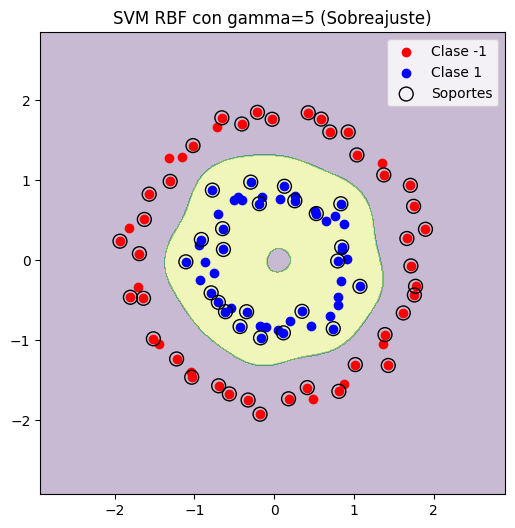

In [34]:

svc_rbf_high_gamma = svm.SVC(kernel='rbf', C=1.0, gamma=5)
svc_rbf_high_gamma.fit(X_poly, y_poly)

plot_decision_boundary(svc_rbf_high_gamma, X_poly, y_poly, 'SVM RBF con gamma=5 (Sobreajuste)')


#### ➡️ Gamma más pequeño (subajuste):

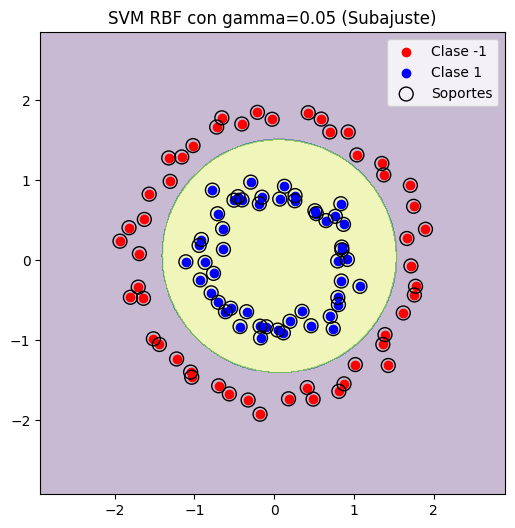

In [35]:

svc_rbf_low_gamma = svm.SVC(kernel='rbf', C=1.0, gamma=0.05)
svc_rbf_low_gamma.fit(X_poly, y_poly)

plot_decision_boundary(svc_rbf_low_gamma, X_poly, y_poly, 'SVM RBF con gamma=0.05 (Subajuste)')


# CASO 2: datos con frontera no lineal y traslape d clases

In [36]:
np.random.seed(12345)

X = np.random.randn(300,2)
X[:100]=X[:100]-2
X[201:]=X[201:]+2.5
y = np.concatenate([np.repeat(-1,100),np.repeat(1,100),np.repeat(-1,100)])
df_0 = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
df_0.columns= ['x1','x2','y']
df_0.head()

,x1,x2,y
0,-2.204708,-1.521057,-1
1,-2.519439,-2.555730,-1
2,-0.034219,-0.606594,-1
3,-1.907092,-1.718254,-1
4,-1.230977,-0.753565,-1


<Axes: xlabel='x1', ylabel='x2'>

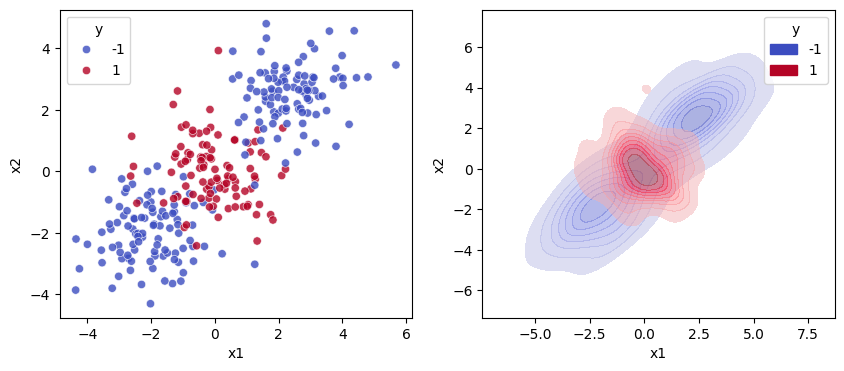

In [38]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
sns.scatterplot(
    data=df_0,
    x="x1",
    y="x2",
    hue="y",  # Diferencia puntos según las etiquetas
    palette="coolwarm",  # Paleta de colores para -1 y 1
    alpha=0.8  # Transparencia
)

plt.subplot(1,2,2)
sns.kdeplot(
    data=df_0,
    x="x1",
    y="x2",
    hue="y",
    fill=True,  # Para sombrear las áreas de densidad
    alpha=0.5,  # Transparencia
    palette="coolwarm"  # Paleta de colores
)


In [39]:
# Función para graficar la frontera de decisión de un SVM
def plot_svc(model, X, y, h=0.02, title="SVM con Kernel RBF"):
    """
    Grafica la frontera de decisión de un clasificador SVM, los márgenes y los vectores de soporte.
    """
    # Crear una cuadrícula de puntos
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predecir en cada punto de la cuadrícula
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Crear el gráfico
    plt.figure(figsize=(5, 5))
    plt.contourf(xx, yy, Z, alpha=0.5, cmap="coolwarm")

    # Graficar los puntos de datos
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolors="k")
    
    # Agregar vectores de soporte
    plt.scatter(
        model.support_vectors_[:, 0], model.support_vectors_[:, 1],
        s=150, facecolors='none', edgecolors='k', marker='o', 
        label="Vectores de soporte", linewidths=1.5
    )
    
    # Configurar el gráfico
    plt.title(title, fontsize=10)
    plt.xlabel("X1", fontsize=8)
    plt.ylabel("X2", fontsize=8)
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


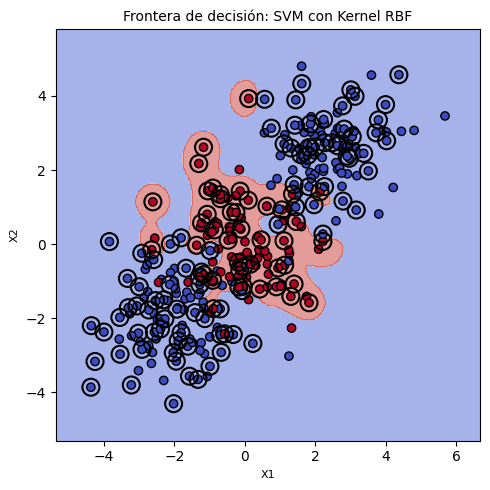

In [43]:
X = df_0[['x1', 'x2']].values
y = df_0['y'].values

# Asegurarse de que las etiquetas sean numéricas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # -1 -> 0, 1 -> 1 si fuera necesario

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=666)

# Entrenar el modelo SVM con kernel RBF
svc_rbf = SVC(kernel="rbf", C=10.0, gamma=5) #"scale"
svc_rbf.fit(X_train, y_train)

# Graficar la frontera de decisión
plot_svc(svc_rbf, X, y, title="Frontera de decisión: SVM con Kernel RBF")


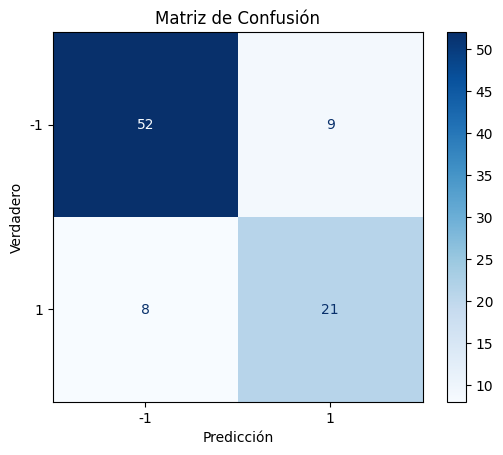

In [45]:
y_pred = svc_rbf.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test,y_pred, labels=svc_rbf.classes_)

# Graficar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_rbf.classes_)
disp.plot(cmap="Blues", values_format="d")

# Ajustar el gráfico
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.grid(False)
plt.show()

In [46]:
from sklearn.model_selection import GridSearchCV
svc = SVC(kernel='rbf')
# Definir la grilla de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [2,1, 0.1, 0.01, 0.001]
}

# Configurar el GridSearchCV
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',  # Métrica para evaluar
    cv=5,  # Número de particiones para validación cruzada
    verbose=2,  # Muestra el progreso
    n_jobs=-1  # Usa todos los núcleos disponibles
)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros y resultados
print("Mejor combinación de hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación promedio en CV:", grid_search.best_score_)

# Reporte detallado para cada configuración
results = pd.DataFrame(grid_search.cv_results_)
print("\nResultados detallados:")
print(results[['param_C', 'param_gamma', 'mean_test_score', 'std_test_score']])


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejor combinación de hiperparámetros: {'C': 0.1, 'gamma': 0.1}
Mejor puntuación promedio en CV: 0.919047619047619

Resultados detallados:
    param_C  param_gamma  mean_test_score  std_test_score
0       0.1        2.000         0.766667        0.050843
1       0.1        1.000         0.861905        0.034993
2       0.1        0.100         0.919048        0.041513
3       0.1        0.010         0.661905        0.009524
4       0.1        0.001         0.661905        0.009524
5       1.0        2.000         0.900000        0.055123
6       1.0        1.000         0.900000        0.048562
7       1.0        0.100         0.919048        0.044160
8       1.0        0.010         0.661905        0.009524
9       1.0        0.001         0.661905        0.009524
10     10.0        2.000         0.876190        0.048562
11     10.0        1.000         0.890476        0.064944
12     10.0        0.100         0.914286     

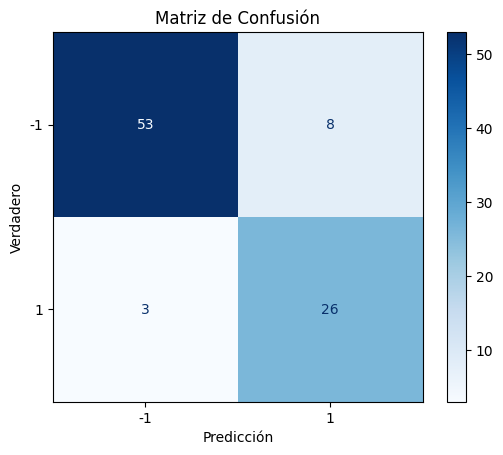

In [47]:
y_pred = grid_search.best_estimator_.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test,y_pred, labels=svc_rbf.classes_)

# Graficar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_rbf.classes_)
disp.plot(cmap="Blues", values_format="d")

# Ajustar el gráfico
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.grid(False)
plt.show()

---

### Resumen de los hiperparámetros
| **Kernel**     | **Hiperparámetros** | **Efecto**                                                |
|----------------|---------------------|-----------------------------------------------------------|
| **Lineal**     | $ C $             | Penaliza errores de clasificación vs. amplitud del margen |
| **Polinómico** | $ C, \gamma, d, r $| Complejidad (grado), escala, y penalización de errores    |
| **RBF**        | $ C, \gamma $    | Flexibilidad de la frontera vs. regularización            |

-----
- **Kernel lineal**: útil cuando los datos son **linealmente separables** o si la dimensión de los datos es **muy alta**.
- **Kernel polinómico**: puede capturar **relaciones no lineales**, pero el grado debe ajustarse con cuidado para evitar **sobreajuste**.
- **Kernel RBF (Gaussiano)**: extremadamente flexible, ideal para **datos no linealmente separables**, pero sensible a los parámetros **gamma** y **C**.

